# Exploratory Data Analysis

## Libraries

In [1]:
# import other files
import sys

sys.path.append("..")

In [21]:
# common functions
from common import missing_data_check, plot_histograms
# fetch functions
from etl.fetch import *
# environment variables
from dotenv import load_dotenv
import os
# data visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
# working with data
import numpy as np
from collections import Counter
from itertools import chain
from sklearn.preprocessing import MinMaxScaler

## Consolidating Data

In [3]:
# load environment variables
load_dotenv()

like_playlist_id = os.getenv("LIKE_PLAYLIST_ID")
dislike_playlist_id = os.getenv("DISLIKE_PLAYLIST_ID")

token = get_token()

'''
Personal playlist columns:
- artist_id, track_id, track_name, popularity, user_like
'''
like_playlist = get_playlist_tracks(token, like_playlist_id)
like_playlist['user_like'] = True
dislike_playlist = get_playlist_tracks(token, dislike_playlist_id)
dislike_playlist['user_like'] = False
songs = pd.concat([like_playlist, dislike_playlist])

'''
Track feature columns:
- 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
    'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
    'time_signature'
'''
track_ids = ','.join(songs.track_id.to_list())
track_features = get_track_features(token, track_ids).drop(columns=['analysis_url', 'track_href', 'type', 'uri'])

'''
Artist feature columns:
- 'artist_id', 'genres', 'name', 'popularity'
'''
artist_ids = ','.join(songs.artist_id.to_list())
artist_features = get_artist_attribute(token, artist_ids).drop(columns=['name', 'popularity'])

2023-11-21 20:48:48 INFO Fetching tracks...
2023-11-21 20:48:49 INFO Fetching tracks...
2023-11-21 20:48:50 INFO Fetching track features...
2023-11-21 20:48:52 INFO Fetching artist(s)...


## Exploratory Analysis

In [4]:
missing_data_check(track_features)

,Total,Percent,Types
danceability,0,0.0,float64
energy,0,0.0,float64
key,0,0.0,int64
loudness,0,0.0,float64
mode,0,0.0,int64
speechiness,0,0.0,float64
acousticness,0,0.0,float64
instrumentalness,0,0.0,float64
liveness,0,0.0,float64
valence,0,0.0,float64


In [6]:
track_features.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000
mean,0.620576,0.611049,5.178794,-7.284696,0.677755,0.076979,0.303171,0.034645,0.174888,0.470012,120.941798,205424.619543,3.941788
std,0.153646,0.230413,3.507321,4.441066,0.467823,0.072500,0.313151,0.141192,0.130686,0.224144,27.682297,52624.108496,0.275265
min,0.130000,0.000116,0.000000,-45.728000,0.000000,0.024800,0.000009,0.000000,0.026400,0.000000,56.926000,87000.000000,3.000000
25%,0.519000,0.437000,2.000000,-8.775000,0.000000,0.037000,0.032200,0.000000,0.097300,0.300000,100.044000,173202.000000,4.000000
50%,0.644000,0.632000,6.000000,-6.442000,1.000000,0.050200,0.164000,0.000006,0.121000,0.450000,120.854000,200613.000000,4.000000
75%,0.732000,0.810000,8.000000,-4.876000,1.000000,0.086100,0.548000,0.000865,0.202000,0.632000,139.056000,225661.000000,4.000000
max,0.970000,0.990000,11.000000,-1.540000,1.000000,0.567000,0.994000,0.973000,0.770000,0.967000,210.164000,740011.000000,5.000000


Checked to see if for any reason any of the tracks have missing audio features. This does not seem to be the case.

We note that:
- key is a categorical variable representing the key the track is in and can range from -1 to 11 (0 to 11 in our case)
- mode is binary and indicates the modality of a track (major or minor) where 1 is major and 0 is minor
- time_signature is an ordinal variable specifying the number of beats in each bar and can range from 3 to 7 (3 to 5 in our case)
- loudness, key, tempo, and duration_ms are continuous numerical variables that we can rescale to range from 0 and 1
- the rest of the variables are continuous numerical and are all already scaled between 0 and 1

In [29]:
# Normalization: X_new = (X — X_min)/ (X_max — X_min)
def normalize(df, features):
    for feature in features:
        df[feature] = (df[feature] - min(df[feature]))/(max(df[feature]) - min(df[feature]))

# normalize the continuous numerical features as mentioned
normalize(track_features, ['loudness', 'key', 'tempo', 'duration_ms'])

In [31]:
track_features.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000
mean,0.620576,0.611049,0.470799,0.869994,0.677755,0.076979,0.303171,0.034645,0.174888,0.470012,0.417754,0.181352,3.941788
std,0.153646,0.230413,0.318847,0.100504,0.467823,0.072500,0.313151,0.141192,0.130686,0.224144,0.180649,0.080587,0.275265
min,0.130000,0.000116,0.000000,0.000000,0.000000,0.024800,0.000009,0.000000,0.026400,0.000000,0.000000,0.000000,3.000000
25%,0.519000,0.437000,0.181818,0.836268,0.000000,0.037000,0.032200,0.000000,0.097300,0.300000,0.281379,0.132007,4.000000
50%,0.644000,0.632000,0.545455,0.889065,1.000000,0.050200,0.164000,0.000006,0.121000,0.450000,0.417181,0.173983,4.000000
75%,0.732000,0.810000,0.727273,0.924504,1.000000,0.086100,0.548000,0.000865,0.202000,0.632000,0.535964,0.212341,4.000000
max,0.970000,0.990000,1.000000,1.000000,1.000000,0.567000,0.994000,0.973000,0.770000,0.967000,1.000000,1.000000,5.000000


In [32]:
songs.user_like.describe()

count       481
unique        2
top       False
freq        284
Name: user_like, dtype: object

Of the 481 songs in the dataset, 284 are labelled dislike (59%) and 197 are labelled like (41%). This imbalance should be noted for later when the dataset is split into training/testing and during modelling as well.

In [33]:
def missing_genres_check(dataframe):
    data = dataframe.copy(deep=True)
    data['is_missing_genre'] = data.genres.astype(bool)    
    total = data.is_missing_genre[data.is_missing_genre == False].count()
    pct = (total / data.is_missing_genre.count()) * 100
    result = pd.DataFrame({'Total':total, 'Percent':pct}, index=['is_missing_genre'])
    return result

missing_genres_check(artist_features)

,Total,Percent
is_missing_genre,61,13.28976


We have that ~13% of the artists in my personal playlist are missing genres. This might be because these artists are not as well known and so Spotify has yet to assign them a genre.

An interesting observation is that genres are associated with an artist rather than a song. If I were to associate a song's genre(s) by its artist(s), this would mean that the song would belong to all of the genres of all of the participating artists. This assumption may cause problems when a particular artist has multiple genres that are vastly different but I will proceed this way for simplicity's sake.

In [11]:
# Build final dataframe
df = songs.merge(track_features, how='inner', left_on='track_id', right_on='id').drop(columns=['id'])
# Split up artist ids
df[['artist_id1', 'artist_id2', 'artist_id3', 'artist_id4', 'artist_id5']] = df['artist_id'].str.split(',', expand=True)
# Join in genres on artist ids
df = df.drop(columns=['artist_id'])
df = df.merge(artist_features, how='left', left_on='artist_id1', right_on='artist_id').drop(columns=['artist_id', 'artist_id1']).rename(columns={'genres':'genres1'})
df = df.merge(artist_features, how='left', left_on='artist_id2', right_on='artist_id').drop(columns=['artist_id', 'artist_id2']).rename(columns={'genres':'genres2'})
df = df.merge(artist_features, how='left', left_on='artist_id3', right_on='artist_id').drop(columns=['artist_id', 'artist_id3']).rename(columns={'genres':'genres3'})
df = df.merge(artist_features, how='left', left_on='artist_id4', right_on='artist_id').drop(columns=['artist_id', 'artist_id4']).rename(columns={'genres':'genres4'})
df = df.merge(artist_features, how='left', left_on='artist_id5', right_on='artist_id').drop(columns=['artist_id', 'artist_id5']).rename(columns={'genres':'genres5'})
df = df.replace(np.nan, "")

In [12]:
# Merge lists across columns
def combine_lists(row):
    combined_list = []
    for col in row:        
        if len(col) > 0:   
            combined_list.extend(col)
    return list(set(combined_list))

# Combine genres columns
df['genres'] = df[['genres1', 'genres2', 'genres3', 'genres4', 'genres5']].apply(combine_lists, axis=1)
df = df.drop(columns=['genres1', 'genres2', 'genres3', 'genres4', 'genres5'])


Now visualizing the audio features of songs that I like vs. songs that I do not like...

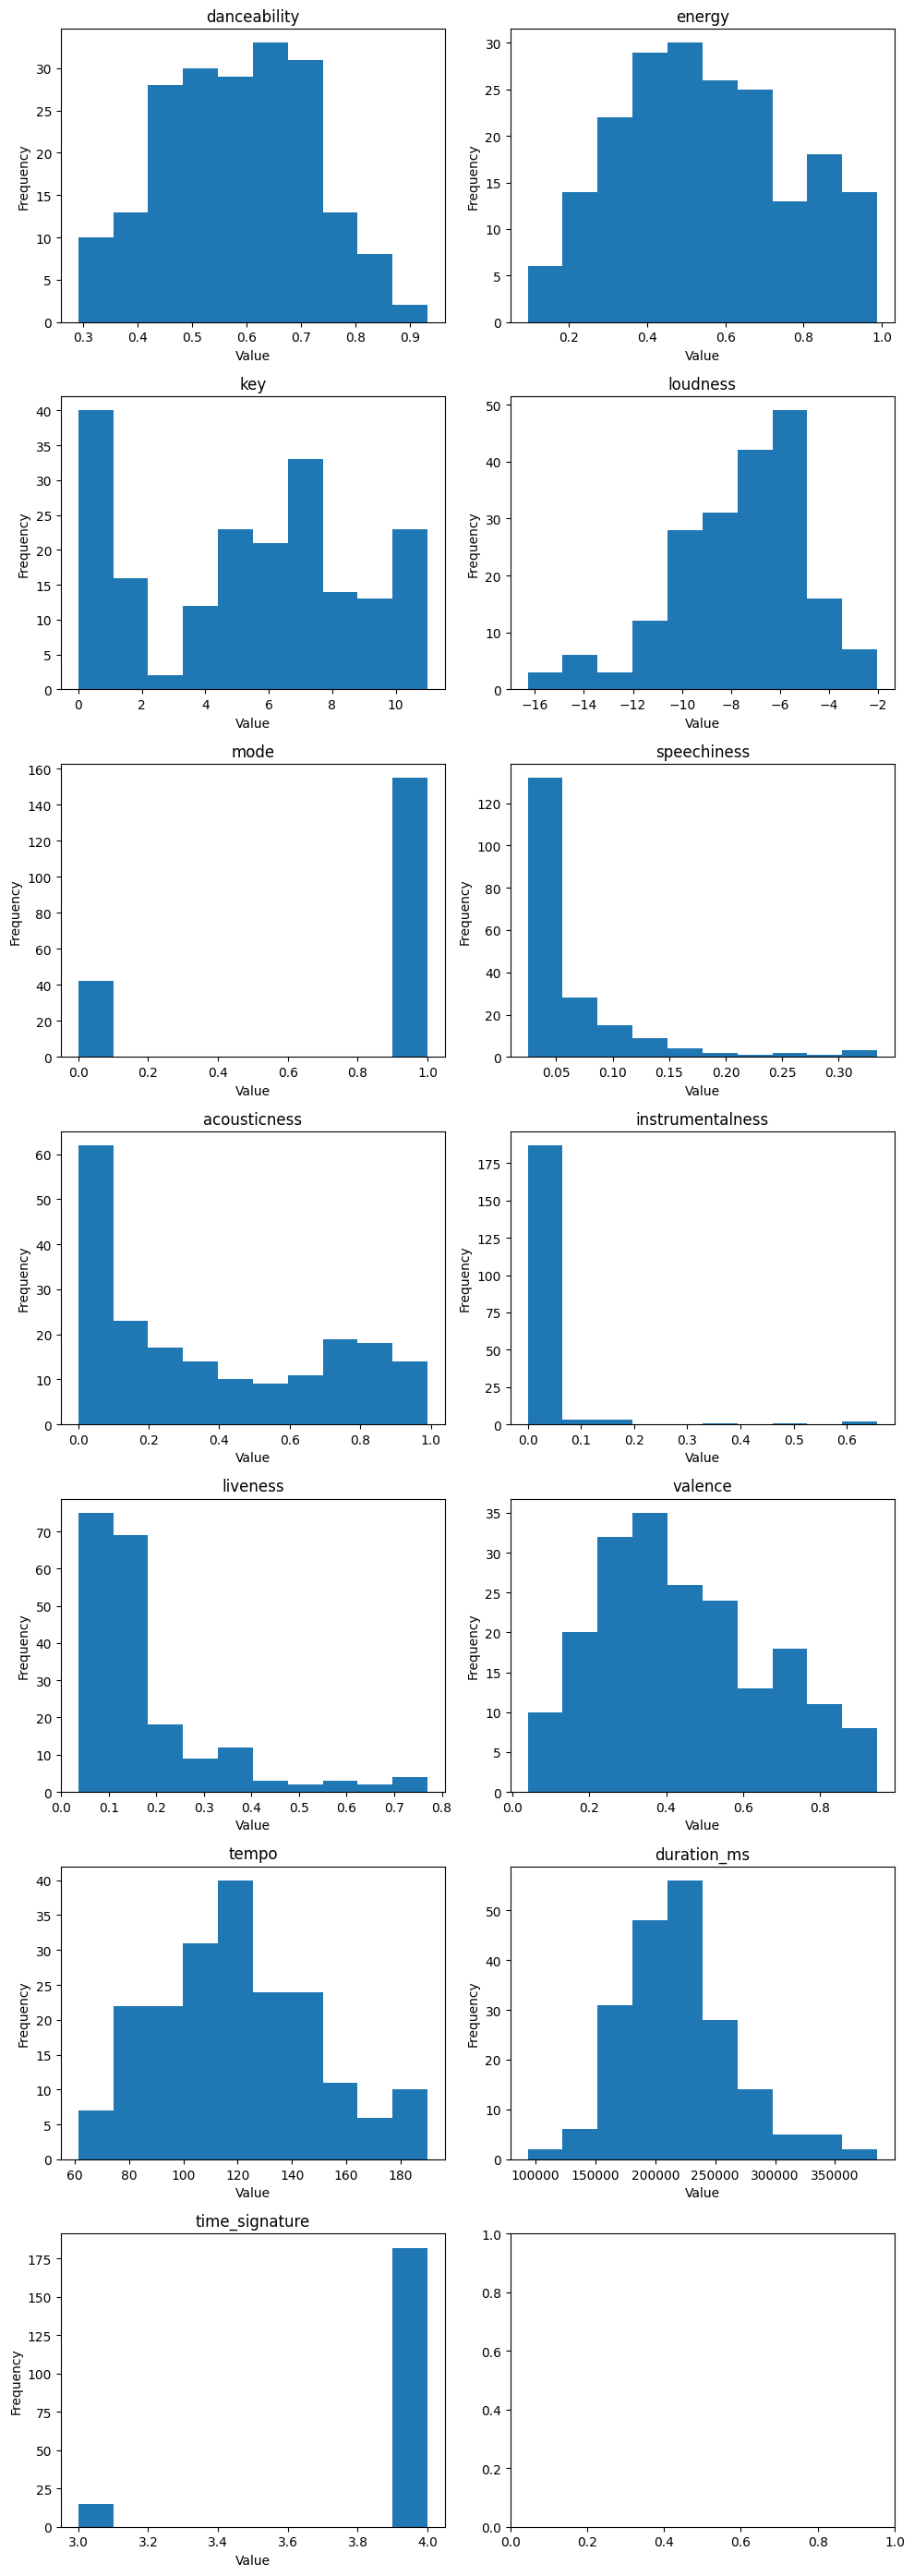

In [13]:
# TODO: data visualization on distribution of audio features
# TODO: data visualization on distribution of genres

features = df[df.user_like == True][['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']]

plot_histograms(features)

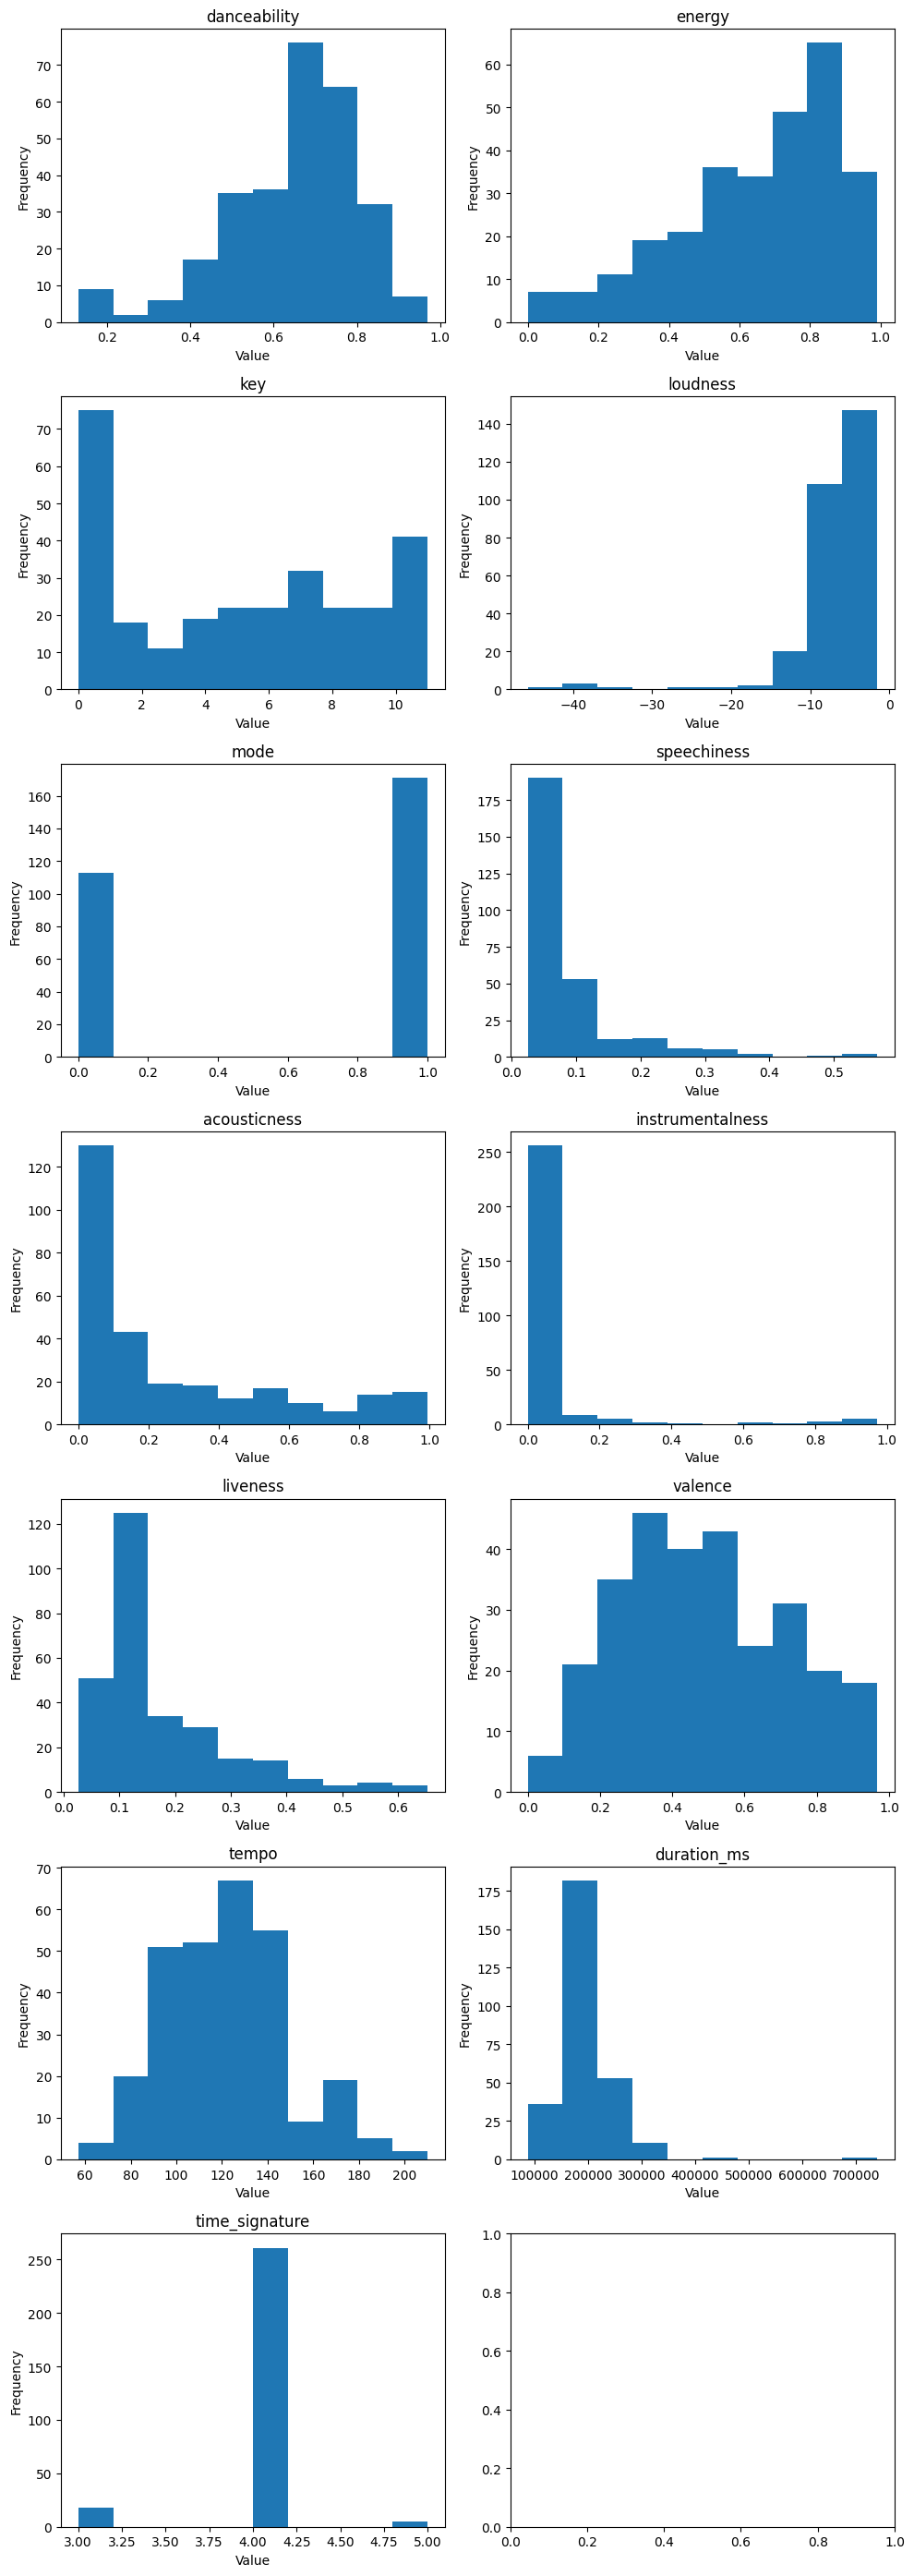

In [39]:
features = df[df.user_like == False][['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']]

plot_histograms(features)

There are 481 songs in total, 197 liked songs and 284 disliked songs. 

Summary of exploratory analysis on audio features:
- Songs that I dislike are on average: 
    - higher in danceability and energy
    - similar in loudness but skewed left heavier (i.e. some songs are a lot louder)
- Other audio features, based on visual inspection, are either similar or have negligible differences


In [40]:
like_genres = df[df.user_like == True]['genres'].explode().value_counts().reset_index()
like_genres.columns = ['Genre', 'Frequency']
dislike_genres = df[df.user_like == False]['genres'].explode().value_counts().reset_index()
dislike_genres.columns = ['Genre', 'Frequency']


In [41]:
like_most_freq_genre = like_genres[like_genres.Frequency == max(like_genres.Frequency)]
like_least_freq_genre = like_genres[like_genres.Frequency == min(like_genres.Frequency)]
dislike_most_freq_genre = dislike_genres[dislike_genres.Frequency == max(dislike_genres.Frequency)]
dislike_least_freq_genre = dislike_genres[dislike_genres.Frequency == min(dislike_genres.Frequency)]

In [42]:
like_most_freq_genre, dislike_most_freq_genre

(  Genre  Frequency
 0   pop         60,
   Genre  Frequency
 0   pop         69)

In [43]:
like_least_freq_genre, dislike_least_freq_genre

(                     Genre  Frequency
 69              dance rock          1
 70                new wave          1
 71                    soul          1
 72            new romantic          1
 73               pop dance          1
 ..                     ...        ...
 135     italian soundtrack          1
 136       psychedelic rock          1
 137              folk rock          1
 138  charlottesville indie          1
 139       stomp and holler          1
 
 [71 rows x 2 columns],
                           Genre  Frequency
 117  christian alternative rock          1
 118               soulful house          1
 119                pop nacional          1
 120                  deep house          1
 121                         ccm          1
 ..                          ...        ...
 296                     norteno          1
 297         musica chihuahuense          1
 298              reggaeton flow          1
 299               pop reggaeton          1
 300             chris

In [46]:
missing_genres_check(df[df.user_like == True]), missing_genres_check(df[df.user_like == False])

(                  Total   Percent
 is_missing_genre     11  5.583756,
                   Total   Percent
 is_missing_genre     23  8.098592)

Of the 482 songs in total, 34 songs are missing genres where 11 are liked songs and 23 are disliked songs.

Of the liked songs the pop genre is the most frequent. In fact, 60 songs are considered pop songs making up ~30% of all liked songs. On the otherhand, 71 genres amongst liked songs are only assigned to one song.

Of the disliked songs the pop genre is also the most frequent. 69 songs are considered pop songs making up ~24% of all disliked songs and 184 genres only have one song associated with them.

Judging from the sparsity of genres, this may indicate that genres, at least in how I attributed them to each song, may not be a very useful feature to include. I'll keep this in mind as I build my models.

## Write To CSV

In [47]:
# relabelling for model building
df.user_like.replace({True: 1, False: 0}, inplace=True)
df.to_csv("songs.csv", index=False)